In [74]:
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import emoji
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')

In [75]:
df = pd.read_csv('IMDB_Dataset.csv')

In [76]:
print(df.shape)
print(df.info())
print(df.isna().sum())
print("Duplicates:", df.duplicated().sum())
print(df['sentiment'].value_counts(normalize=True))

(50000, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB
None
review       0
sentiment    0
dtype: int64
Duplicates: 418
sentiment
positive    0.5
negative    0.5
Name: proportion, dtype: float64


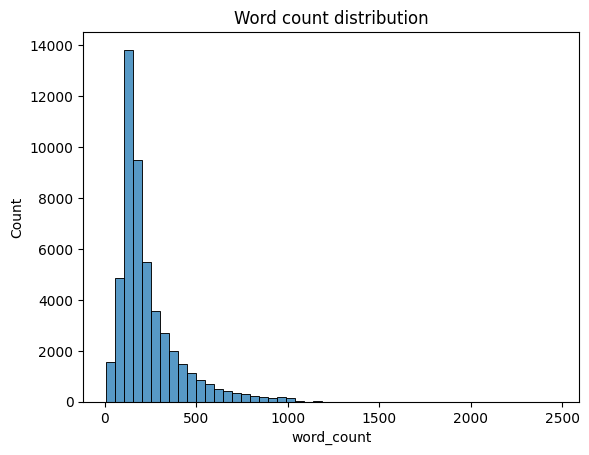

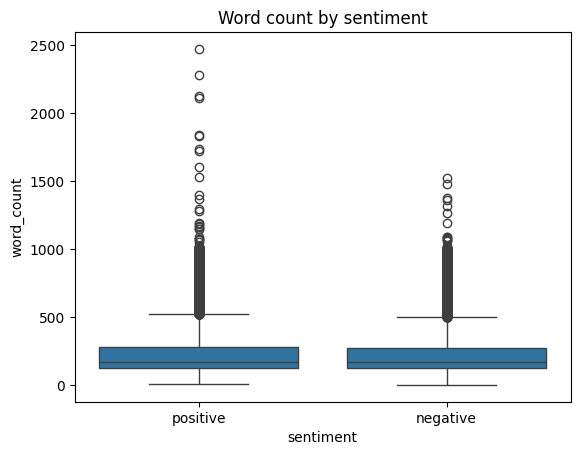

In [77]:
df['char_count'] = df['review'].str.len()
df['word_count'] = df['review'].str.split().apply(len)

sns.histplot(df['word_count'], bins=50)
plt.title("Word count distribution")
plt.show()

sns.boxplot(x='sentiment', y='word_count', data=df)
plt.title("Word count by sentiment")
plt.show()

In [78]:
all_words = set(" ".join(df['review']).split())
print("Vocabulary size:", len(all_words))

Vocabulary size: 438729


In [79]:
vec = CountVectorizer(stop_words='english')
bag = vec.fit_transform(df['review'])
word_freq = bag.sum(axis=0).A1
words = vec.get_feature_names_out()
rare_words = [words[i] for i, freq in enumerate(word_freq) if freq == 1]
print("Rare words count:", len(rare_words))

Rare words count: 38817


In [80]:
df = df.drop_duplicates()

def clean_text(s):
    if pd.isna(s): 
        return ""
    s = re.sub(r"<.*?>", " ", s)           
    s = re.sub(r"\s+", " ", s).strip()     
    return s.lower()

df['review'] = df['review'].astype(str).map(clean_text)
df = df[df['review'].str.len() > 0].reset_index(drop=True)

In [81]:
def expand_contractions(text):
    replacements = {
    "can't": "cannot", "won't": "will not", "n't": " not",
    "'re": " are", "'s": " is", "'d": " would",
    "'ll": " will", "'t": " not", "'ve": " have", "'m": " am"
    }
    for c, full in replacements.items():
        text = re.sub(c, full, text)
    return text

def normalize_quotes_dashes(text):
    replacements = {
        "“": '"', "”": '"', "‘": "'", "’": "'",
        "–": "-", "—": "-", "…": "...",
    }
    for old, new in replacements.items():
        text = text.replace(old, new)
    return text

def emoji_to_text(text):
    return emoji.demojize(text, language='en')

def normalize_repeated_chars(text):
    return re.sub(r'(.)\1{2,}', r'\1\1', text)

In [82]:
def full_clean(text):
    text = normalize_quotes_dashes(text)
    text = expand_contractions(text)
    text = emoji_to_text(text)
    text = normalize_repeated_chars(text)
    return text

df['review'] = df['review'].astype(str).apply(full_clean)

In [83]:
le = LabelEncoder()
df['sentiment'] = le.fit_transform(df['sentiment'])

In [84]:
vec = TfidfVectorizer(ngram_range=(1,2), max_features=100000, min_df=3)
clf = LogisticRegression(solver='saga', max_iter=2000, C=1.0, class_weight='balanced')

model = make_pipeline(vec, clf)

In [85]:
X = df['review'].values
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [86]:
model.fit(X_train,y_train)

,steps,"[('tfidfvectorizer', ...), ('logisticregression', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


In [87]:
y_pred = model.predict(X_test)
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.89      0.92      0.90      4804
           1       0.92      0.89      0.91      5113

    accuracy                           0.91      9917
   macro avg       0.91      0.91      0.91      9917
weighted avg       0.91      0.91      0.91      9917

